### Importing libraries

In [1]:
# pip install tensorflow
# check out https://www.tensorflow.org/tutorials/images/cnn
# can run and compare results in colab

In [22]:
import os
import pandas as pd
import numpy as np

# import required libaries to process images
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
 
#using Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential

### Importing and examining the images

In [3]:
# follow this on zero padding vs resizing and how it effects accuracy 
# mabye something we talk to Jiaqi about
def pad_images(images, width_max, length_max): 
    padded_images = [] 
    c = 0 
    for image in images: 
        wpad1 = (width_max - image.shape[0])/2
        lpad1 = (length_max - image.shape[1])/2

        if lpad1%1 > 0: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)+1
        else: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)

        if wpad1%1 > 0: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)+1
        else: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)
        try:
            padded_images.append(np.pad(image, pad_width=[(wpad1 , wpad2),(lpad1, lpad2),(0, 0)], mode='constant'))
        except: 
            print("at {}".format(c))
        c = c + 1
    return padded_images

In [4]:
#crop images to center based on full dataset mean_size
def crop_images(images, width_mean, length_mean):
    train_padded_c = []
    for image in images: 
        
        left = int((image.shape[0] - int(width_mean))/2)
        top = int((image.shape[1] - int(length_mean))/2)
        right = int((image.shape[0] + int(width_mean))/2)
        bottom = int((image.shape[1] + int(length_mean))/2)

        train_padded_c.append(image[left:right, top:bottom])
    return train_padded_c

In [5]:
def load_images():

    #get list of images from corsican
    dir = os.getcwd()
    images = os.listdir('{}/assets/wildfire_test_set'.format(dir))
    image_file = [file for file in images if '.DS_Store' not in file]
    fire_image_arrays = [np.asarray(Image.open('{}/assets/wildfire_test_set/{}'.format(dir,image))) for image in image_file]
    fire_label_arrays = []
    for array in fire_image_arrays:
        fire_label_arrays.append([1])

    #get images for fire-less mountains
    images = os.listdir('{}/assets/mountain_test_set'.format(dir))
    image_file = [file for file in images if '.DS_Store' not in file]
    mountain_image_arrays = [np.asarray(Image.open('{}/assets/mountain_test_set/{}'.format(dir,image))) for image in image_file] 
    mountain_label_arrays = []
    for array in mountain_image_arrays:
        mountain_label_arrays.append([0])

    all_image_arrays = fire_image_arrays + mountain_image_arrays
    
    #calculate the mean widths and heights of the images 
    widths = [array.shape[0] for array in all_image_arrays]
    lengths = [array.shape[1] for array in all_image_arrays]
    width_mean = np.mean(widths)
    length_mean = np.mean(lengths)
    width_max = np.max(widths)
    length_max = np.max(lengths)
    
    #pad and crop images 
    all_image_arrays = pad_images(all_image_arrays, width_max, length_max)
    all_image_arrays = crop_images(all_image_arrays, width_mean, length_mean)
    
    all_image_labels = fire_label_arrays + mountain_label_arrays

    data = list(zip(all_image_arrays, all_image_labels))

    return data
data = load_images()

In [6]:
def test_train_split(data):
    # randomize the images
    import random 
    random.seed(42)
    random.shuffle(data)

    #split into train, test, dev
    data_len = len(data)
    train, dev, test = np.split(data, [int(data_len*.8),int(data_len*.9)])
    train_images, train_labels = zip(*train)
    dev_images, dev_labels = zip(*dev)
    test_images, test_labels = zip(*test)
    
    return train_images, train_labels, dev_images, dev_labels, test_images, test_labels
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(data)

C:\Users\npess\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0,

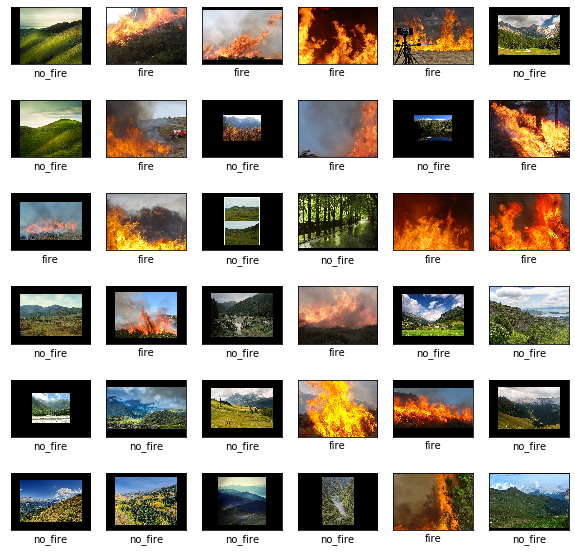

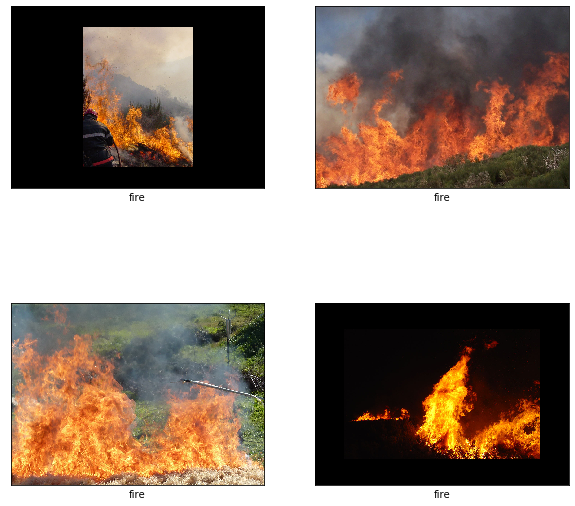

In [8]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = math.floor(math.sqrt(len(images)))

    class_names = ['no_fire','fire']
    plt.figure(figsize=(10,10))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])
    
plot_images(train_images, train_labels)
plot_images(test_images, test_labels)

In [9]:
train_images.shape

(40, 952, 1328, 3)

In [10]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

In [11]:
# train_images[0].shape

In [12]:
#checking out the shape for standardization
def shaping (all_images):
    width_means = []
    length_means = []
    for array in all_images:

    #     print(array.shape)

        #width to length ratio
    #     print(array.shape[0]/array.shape[1])

        #width & length means
        width_means.append(array.shape[0])
        length_means.append(array.shape[1])

    width_mean = np.mean(width_means)
    length_mean = np.mean(length_means)

    print(' ')
    print('----------------')
    print('width mean')
    print(width_mean)
    print('----------------')
    print('length mean')
    print(length_mean)
    return None

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(952, 1328, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 950, 1326, 32)     896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 475, 663, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 473, 661, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 236, 330, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 234, 328, 64)      36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 950, 1326, 32)     896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 475, 663, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 473, 661, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 236, 330, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 234, 328, 64)      36928     
_________________________________________________________________
flatten (Flatten)            (None, 4912128)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [17]:
epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
2/2 [==============================] - 132s 34s/step - loss: 9.9179 - accuracy: 0.1000 - val_loss: 106.8771 - val_accuracy: 0.8000
Epoch 2/10
2/2 [==============================] - 123s 22s/step - loss: 148.9827 - accuracy: 0.4250 - val_loss: 19.8681 - val_accuracy: 0.6000
Epoch 3/10
2/2 [==============================] - 132s 23s/step - loss: 19.5438 - accuracy: 0.6750 - val_loss: 21.3017 - val_accuracy: 0.4000
Epoch 4/10
2/2 [==============================] - 229s 23s/step - loss: 6.3951 - accuracy: 0.6750 - val_loss: 13.4132 - val_accuracy: 0.4000
Epoch 5/10
2/2 [==============================] - 182s 22s/step - loss: 4.9720 - accuracy: 0.8250 - val_loss: 6.9160 - val_accuracy: 0.6000
Epoch 6/10
2/2 [==============================] - 169s 23s/step - loss: 1.1991 - accuracy: 0.9000 - val_loss: 7.0154 - val_accuracy: 0.6000
Epoch 7/10
2/2 [==============================] - 174s 22s/step - loss: 1.0929 - accuracy: 0.9500 - val_loss: 4.9931 - val_accuracy: 0.8000
Epoch 8/10
2

1/1 - 13s - loss: 0.0000e+00 - accuracy: 1.0000


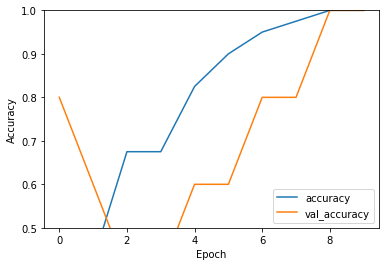

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

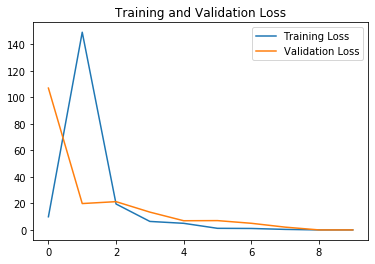

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data augmentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(952, 1328, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

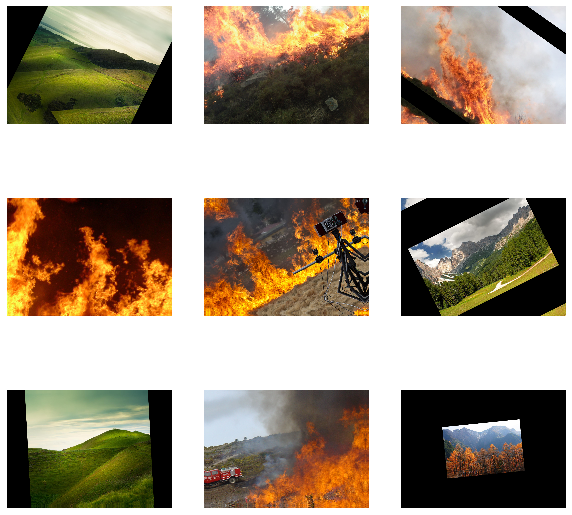

In [39]:
plt.figure(figsize=(10, 10))
# for images in train_images:
for i in range(9):
    augmented_images = data_augmentation(train_images[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images)#.numpy().astype("uint8"))
    plt.axis("off")

In [41]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 952, 1328, 3)      0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 952, 1328, 3)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 952, 1328, 16)     448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 476, 664, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 476, 664, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 238, 332, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 238, 332, 64)     

In [45]:
epochs = 10
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 78s 22s/step - loss: 1.4707 - accuracy: 0.2750 - val_loss: 4.7912 - val_accuracy: 0.2000
Epoch 2/10
2/2 [==============================] - 37s 19s/step - loss: 2.0776 - accuracy: 0.5750 - val_loss: 0.6110 - val_accuracy: 0.8000
Epoch 3/10
2/2 [==============================] - 36s 19s/step - loss: 0.8112 - accuracy: 0.4250 - val_loss: 0.6410 - val_accuracy: 0.8000
Epoch 4/10
2/2 [==============================] - 37s 19s/step - loss: 0.8880 - accuracy: 0.4250 - val_loss: 0.5386 - val_accuracy: 0.8000
Epoch 5/10
2/2 [==============================] - 37s 20s/step - loss: 0.8484 - accuracy: 0.4250 - val_loss: 0.7381 - val_accuracy: 0.4000
Epoch 6/10
2/2 [==============================] - 36s 19s/step - loss: 0.7089 - accuracy: 0.6500 - val_loss: 1.0443 - val_accuracy: 0.2000
Epoch 7/10
2/2 [==============================] - 36s 19s/step - loss: 0.7328 - accuracy: 0.5750 - val_loss: 1.0665 - val_accuracy: 0.2000
Epoch 8/10
2/2 [===========